# Phase-Matching Function Optimization with genetic algorithm

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c
import numdifftools as nd
from GaPmf.medium.Medium import Medium
from GaPmf.medium.Crystal import Crystal
import GaPmf.utils.utils as ut
from GaPmf.utils.Visualizer import Visualizer
from GaPmf.optimization.GA import GA

### Define the central wavelengths of the two downconverted modes and the pump

In [2]:
wavelength_s_0 = 1.582e-6   # signal mode central wavelength [m]
omega_s_0 = 2*np.pi*c/wavelength_s_0 # signal central frequency [rad/s]
wavelength_i_0 = 1.582e-6   # idler mode central wavelength [m]
omega_i_0 = 2*np.pi*c/wavelength_i_0 # idler central frequency [rad/s]
wavelength_p_0 = 1/(1/wavelength_s_0 + 1/wavelength_i_0)  # pump mode central wavelength [m]
omega_p_0 = 2*np.pi*c/wavelength_p_0 # pump central frequency [rad/s]
medium_type = 'KTP'
signal = 'y'
idler = 'z'
pump = 'y'

# define medium and print coherence length for the given wavelengths
medium = Medium(medium_type, signal, idler, pump, wavelength_p_0)
print(f'domain width = {medium.domain_width*1e6:3e} um')

domain width = 2.447018e+01 um


### Transition to the frequency domain 

In [3]:
# full width at half maximum
FWHM_wavelength = 30*1e-9
# mulltiply step by 2 for 0.5nm resolution
wavelength_range = 8*FWHM_wavelength
wavelength_step = int(8*FWHM_wavelength*1e9)
wavelength_array = np.linspace(wavelength_s_0 - wavelength_range/2, wavelength_s_0 + wavelength_range/2, wavelength_step)
# convert FWHM ro frequency
FWHM_freq = ut.waveBW_to_spectrBW(FWHM_wavelength, wavelength_s_0)

# define frequency range
omega_range = 8*FWHM_freq
omega_step = 100
omega_s = np.linspace(omega_s_0 - omega_range/2,omega_s_0 + omega_range/2, omega_step)
omega_i = np.linspace(omega_i_0 - omega_range/2,omega_i_0 + omega_range/2, omega_step)

### Define Target function

In [4]:
# calculate wavenumber derivative at signal/idler central frequency
k_s_gradient = nd.Gradient(medium.k_s,step=1.0e10)([omega_s_0])
k_i_gradient = nd.Gradient(medium.k_i,step=1.0e10)([omega_i_0])
# calculate group velocity dispersion
gvd = k_s_gradient-k_i_gradient
# define target function in phase mismatch domain
sigma_k = np.abs(FWHM_freq*gvd/2)
k_range = 15*sigma_k
delta_k_0 = medium.phase_mismatch_function(omega_s_0, omega_i_0)
#N = (int)(k_range/20)
N = 1000
print(f"sigma_k = {sigma_k}")
print(f"N = {N}")
delta_k_pmf = np.linspace(delta_k_0-k_range/2, delta_k_0+k_range/2, N)
gaussian_term_PMF_k = lambda k: np.exp(-(k-delta_k_0)**2/(2*sigma_k**2))
pmf_target = np.abs(gaussian_term_PMF_k(delta_k_pmf))
pmf_target = pmf_target / np.linalg.norm(np.abs(pmf_target))

sigma_k = 3195.0089727290933
N = 1000


Plot Target Function

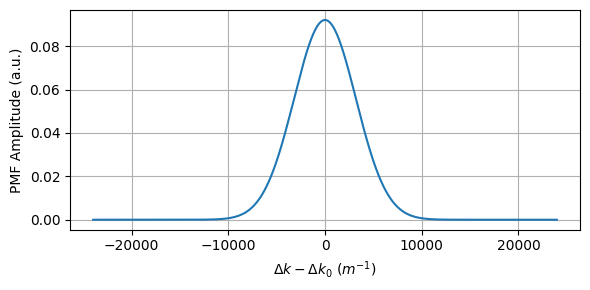

In [5]:
# Create a figure with 1 row and 2 columns
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# Plot the target and simulated PMF profiles for the signal
ax.plot(delta_k_pmf - delta_k_0, np.abs(pmf_target), label='Target Signal')
ax.set_xlabel(r'$\Delta k - \Delta k_0$ ($m^{-1}$)')
ax.set_ylabel('PMF Amplitude (a.u.)')

# Show the plot
plt.tight_layout()
plt.grid()
plt.show()

### Start The Genetic Algorithm

GENERATION 02
	 - Population length: 2
	 - Avg. Fitness: -0.000116
	 - Avg. Length: 0.001444
	 - Best Crystal
		 -> length: 0.0013703300990405185
		 -> fitness: (-0.000104)
	 - Worst Crystal
		 -> length: 0.0015171511810805741
		 -> fitness: (-0.000127)


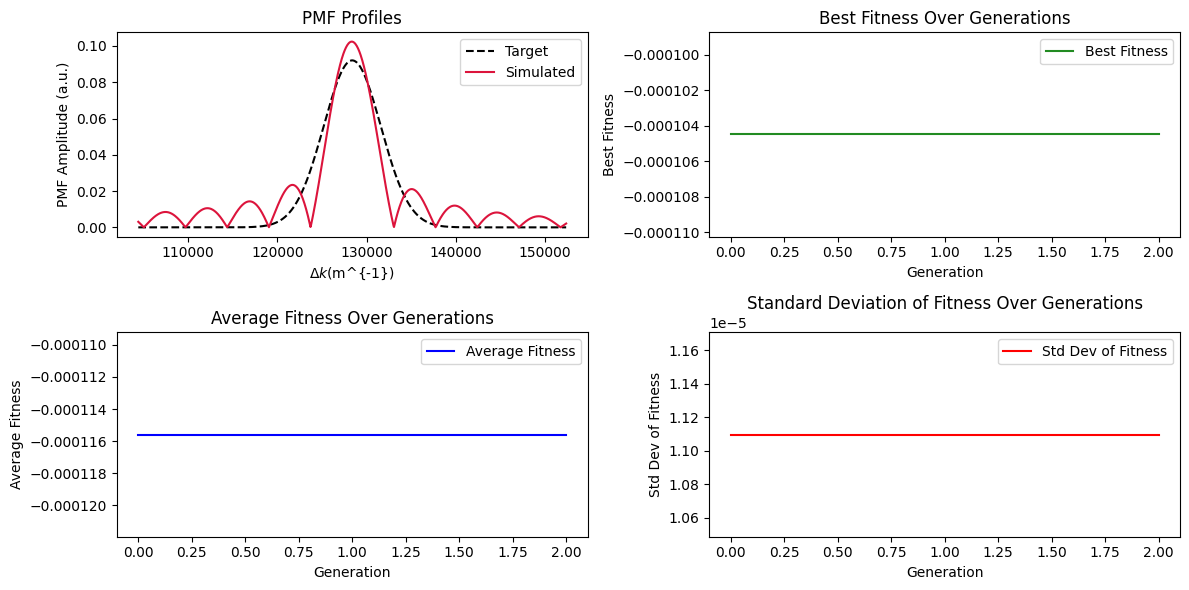

Evolution Progress: 100%|██████████| 3/3 [00:25<00:00,  8.42s/it]


In [6]:
# minimal / maximal crystal length
min_length = 1e-3 # [m]
max_length = 2e-3 # [m]
# initialization option
option = "ppln" # "random" or "ppln"
# size of the population
size = 2
# number of iterations
nb_generation = 3
# uniform crossover probability
Pu1 = 1
Pu2 = 1
# weight coefficient for mutation
weight_Pm = 1
# single-point crossover probability
Ps = 1
nb_level = [] # number of levels
restart = None # at which iteration to launch a restart (if None -> no restart)
restart_depth = 990 # how many individuals of the population to change in the restart
mode = 1 # which mode to use for the GA (1 = phase mismatch, 2 = signal/idler frequencies)
domain_width = medium.domain_width # width of each domain
#domain_width = 4e-6
# instance of GA
ga = GA(size, option, Ps, Pu1, Pu2, weight_Pm, mode,
        domain_width, max_length, min_length,
        phase_mismatch_array = delta_k_pmf, pmf_target = pmf_target)
# run GA
p, i = ga.run_evolution(nb_generation, printer=True, nb_level=nb_level, restart=restart, restart_depth=restart_depth)

### Visualize Results

Phase-Matching FUnction

/Users/macoco/Desktop/colin_ecole/polymtl/polymtl_MA1/maîtrise/PPLN/simulations/GaPmf/GaPmf/utils/Visualizer.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


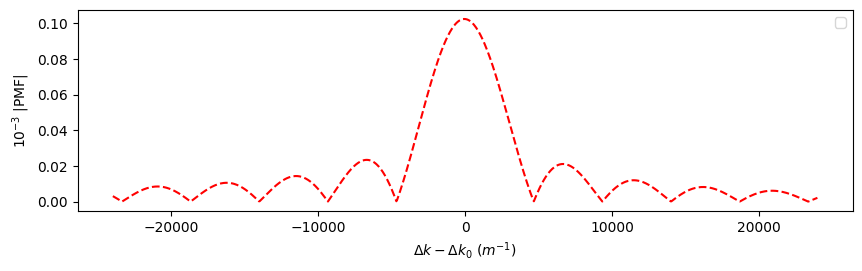

In [7]:
visualizer = Visualizer()
visualizer.plot_pmf(delta_k_pmf, delta_k_0, p[0].pmf)

Genetic Algorithm metrics

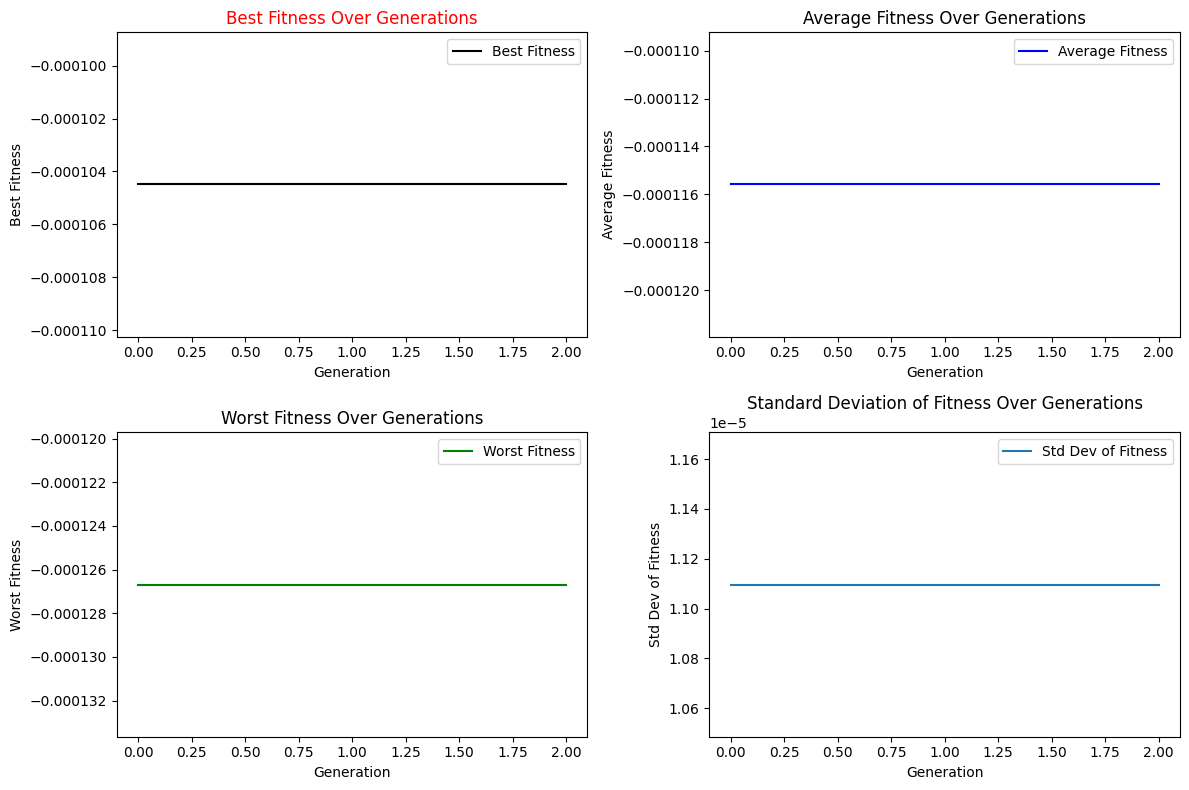

In [8]:
visualizer.plot_ga_metrics(ga.metrics)

Joint Spectral Amplitude (in the first order approximation)

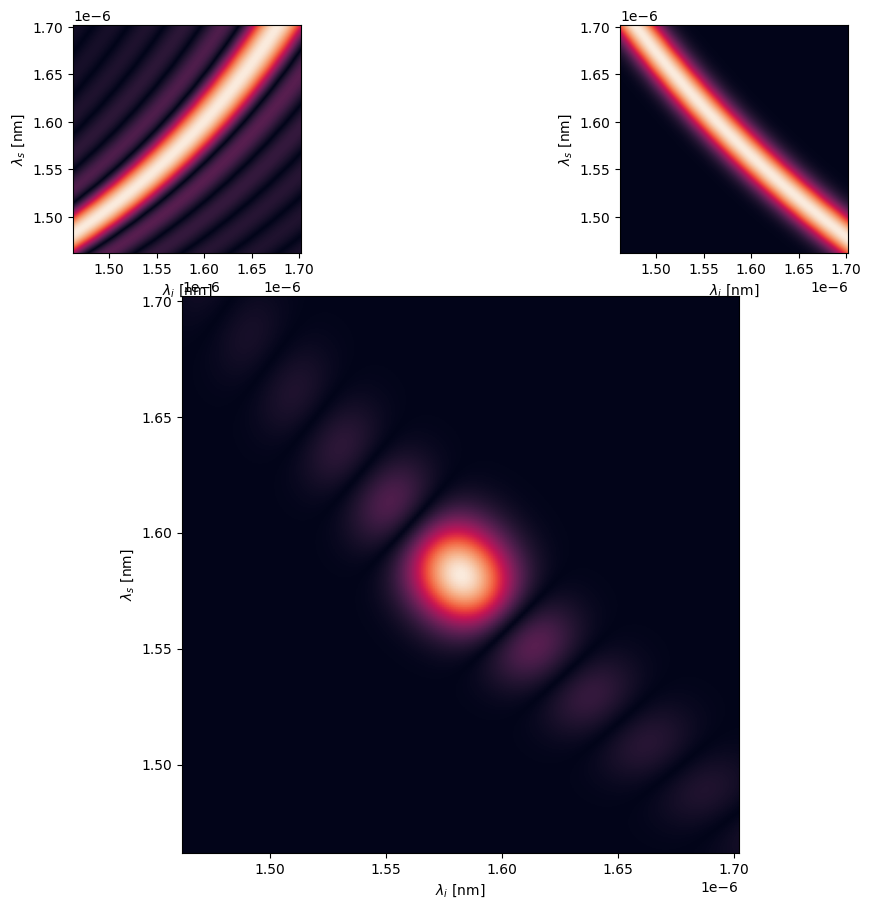

In [16]:
final_crystal = p[0]
pump_FWHM = 12e-9
final_crystal.compute_jsa(wavelength_array, wavelength_array, medium.pump_wavelength, pump_FWHM, ut.pump_gaussian_function, medium.phase_mismatch_function)
visualizer.plot_jsa(final_crystal.jsa, final_crystal.spectral_pmf_matrix, final_crystal.spectral_pump_matrix, wavelength_array, wavelength_array)

In [17]:
final_crystal.compute_purity()

Cooperativity K = 1.1995583876997322


np.float64(1.1995583876997322)